LCA Multi-Category Visualization Tool
This script creates a log-scale plot of all selected impact categories
Please upload your '*_all_impacts.csv' files for all scenarios you want to compare...


Saving Aspergillus_oryzae_all_impacts.csv to Aspergillus_oryzae_all_impacts (1).csv
Saving Neurospora_intermedia_all_impacts.csv to Neurospora_intermedia_all_impacts (1).csv
Saving Rhizopus_delemar_all_impacts.csv to Rhizopus_delemar_all_impacts (1).csv
Loading scenario: Aspergillus_oryzae_all_impacts (1).csv from Aspergillus_oryzae_all_impacts (1).csv
Loading scenario: Neurospora_intermedia_all_impacts (1).csv from Neurospora_intermedia_all_impacts (1).csv
Loading scenario: Rhizopus_delemar_all_impacts (1).csv from Rhizopus_delemar_all_impacts (1).csv

Loaded 3 scenarios: Aspergillus_oryzae_all_impacts (1).csv, Neurospora_intermedia_all_impacts (1).csv, Rhizopus_delemar_all_impacts (1).csv

Would you like to customize the scenario names in the legend? (y/n)
y

For each scenario, enter the display name you want to use in the legend.
Press Enter to keep the original name (with underscores replaced by spaces).
Display name for 'Aspergillus_oryzae_all_impacts (1).csv' (default: 'Aspergill

<ipython-input-3-78c21fd50d04>:189: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


Saved visualization to lca_multi_category_comparison.png


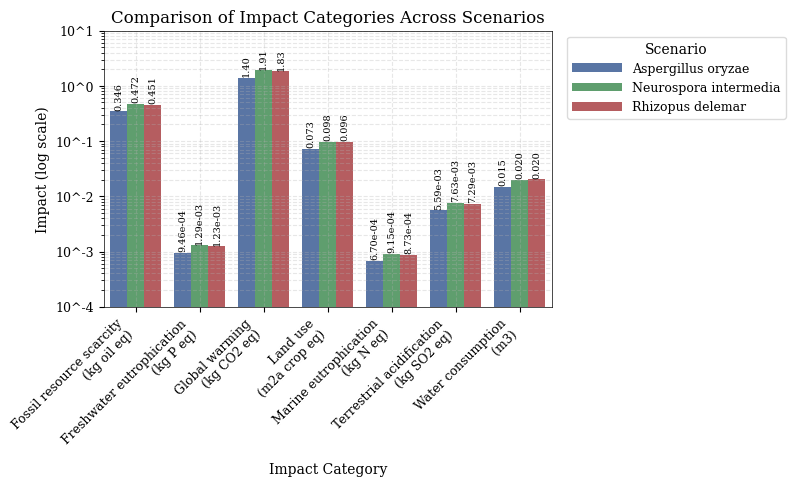


Visualization complete! Saved to lca_multi_category_comparison.png

For Microsoft Word: For best results, insert the image in Word and set the layout to 'In line with text'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from google.colab import files


plt.rcParams.update({

    'figure.figsize': (8.0, 5.0),

    # Font settings - keeping consistent
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,

    # Axes settings
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.linewidth': 0.5,

    # Grid settings
    'grid.linestyle': '--',
    'grid.alpha': 0.3,

    # Legend settings
    'legend.frameon': True,
    'legend.framealpha': 0.7,
    'legend.handlelength': 4.0,

    # Output settings
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Colorblind-friendly palette - keeping the same
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    '#4C72B0', '#55A868', '#C44E52', '#8172B3',
    '#CCB974', '#64B5CD', '#AD8BC9', '#B0724E'
])

def load_scenario_data():
    """
    Interactively load the scenario CSV files for comparison.

    Returns:
        dict: Dictionary with scenario names as keys and dataframes as values
    """
    # Upload CSV files
    print("Please upload your '*_all_impacts.csv' files for all scenarios you want to compare...")
    uploaded = files.upload()

    # Load each CSV file into a dataframe
    scenarios = {}

    for filename in uploaded.keys():
        # Extract scenario name from filename (remove _all_impacts.csv)
        scenario_name = re.sub(r'_all_impacts\.csv$', '', filename)

        # Load the CSV
        print(f"Loading scenario: {scenario_name} from {filename}")
        df = pd.read_csv(filename)

        # Store in scenarios dictionary
        scenarios[scenario_name] = df

    return scenarios

def plot_all_impact_categories(scenarios, selected_categories=None, use_log_scale=True,
                              save_fig=True, fig_filename="lca_multi_category_comparison.png",
                              figsize=(8.0, 5.0), legend_name_mapping=None):

    # If no specific categories are selected, use all available categories
    if selected_categories is None:
        # Get all unique impact categories
        impact_categories = set()
        for df in scenarios.values():
            impact_categories.update(df['Impact category'])
        selected_categories = sorted(list(impact_categories))

    # Create a dataframe for plotting
    plot_data = []

    for category in selected_categories:
        for scenario_name, df in scenarios.items():
            # Filter for the specific impact category
            filtered_df = df[df['Impact category'] == category]

            if not filtered_df.empty:
                value = filtered_df['Total'].values[0]
                unit = filtered_df['Unit'].values[0] if 'Unit' in filtered_df.columns else ''

                # Store data for plotting
                plot_data.append({
                    'Impact Category': category,
                    'Scenario': scenario_name,
                    'Value': value,
                    'Unit': unit
                })

    if not plot_data:
        print("No data found for the selected impact categories")
        return None

    plot_df = pd.DataFrame(plot_data)

    # Group by category to check if we have the same unit for each category
    category_units = plot_df.groupby('Impact Category')['Unit'].first().to_dict()

    # Create figure with increased size
    fig, ax = plt.subplots(figsize=figsize)

    # Create grouped bar chart
    bars = sns.barplot(
        x='Impact Category',
        y='Value',
        hue='Scenario',
        data=plot_df,
        ax=ax
    )

    # Set log scale if requested and customize y-axis ticks
    if use_log_scale:
        ax.set_yscale('log')
        ax.set_ylabel('Impact (log scale)')
        yticks = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"10^{int(np.log10(y))}" for y in yticks])
    else:
        ax.set_ylabel('Impact')

    # Improve x-axis label handling
    plt.xticks(rotation=45, ha='right')

    # Add more bottom margin for x labels
    plt.subplots_adjust(bottom=0.25)  # Increased from default

    # Add value labels on top of bars with improved positioning
    for bar in bars.patches:
        height = bar.get_height()
        # Only add text if the bar is tall enough to be visible
        if height > 0:
            # Format number based on magnitude
            if height < 0.01:
                text = f"{height:.2e}"
            elif height < 1:
                text = f"{height:.3f}"
            elif height < 10:
                text = f"{height:.2f}"
            else:
                text = f"{height:.1f}"

            # Adjusted position to prevent overflow
            y_pos = min(height, ax.get_ylim()[1] * 0.9)  # Cap at 90% of axis height

            bars.annotate(text,
                       (bar.get_x() + bar.get_width() / 2, y_pos),
                       ha='center', va='bottom',
                       fontsize=7,
                       rotation=90,
                       xytext=(0, 1), textcoords='offset points')

    # Add units to the x-axis labels with improved formatting
    new_labels = [f"{cat}\n({category_units[cat]})" for cat in selected_categories]
    ax.set_xticklabels(new_labels)

    # Set plot title
    ax.set_title('Comparison of Impact Categories Across Scenarios')

    # Customize and adjust legend with better positioning
    handles, labels = ax.get_legend_handles_labels()

    # Apply name mapping
    name_mapping = legend_name_mapping or {}
    labels = [name_mapping.get(label, label.replace('_', ' ')) for label in labels]

    # Create custom legend with modified position for better fit
    legend = plt.legend(
        handles,
        labels,
        title='Scenario',
        bbox_to_anchor=(1.02, 1),  # Slight adjustment
        loc='upper left',
        frameon=True,
        framealpha=0.7,
        title_fontsize=10,
        ncol=1
    )

    # Add grid lines
    ax.grid(linestyle='--', alpha=0.3, which='both')

    # Apply tight layout with more padding
    plt.tight_layout(pad=1.2)

    # Save figure if requested
    if save_fig:
        plt.savefig(fig_filename, dpi=600, bbox_inches='tight', pad_inches=0.1)
        print(f"Saved visualization to {fig_filename}")

    return fig

def select_impact_categories(scenarios):
    """
    Allow user to select specific impact categories to visualize.

    Args:
        scenarios (dict): Dictionary with scenario names as keys and dataframes as values

    Returns:
        list: Selected impact categories
    """
    # Get all unique impact categories
    all_categories = set()
    for df in scenarios.values():
        all_categories.update(df['Impact category'])

    all_categories = sorted(list(all_categories))

    # Print available categories with numbers
    print("\nAvailable impact categories:")
    for i, category in enumerate(all_categories, 1):
        print(f"{i}. {category}")

    # Ask user to select categories
    print("\nSelect categories to visualize (comma-separated numbers, or 'all' for all categories):")
    selection = input()

    if selection.lower() == 'all' or selection.strip() == '':
        print("Using all impact categories.")
        return all_categories

    try:
        # Parse user selection
        selected_indices = [int(idx.strip()) - 1 for idx in selection.split(',')]
        selected_categories = [all_categories[idx] for idx in selected_indices if 0 <= idx < len(all_categories)]

        if not selected_categories:
            print("No valid categories selected. Using all categories.")
            return all_categories

        return selected_categories
    except:
        print("Invalid selection. Using all categories.")
        return all_categories

def main():
    """Main function to run the LCA visualization workflow"""
    print("=" * 50)
    print("LCA Multi-Category Visualization Tool")
    print("=" * 50)
    print("This script creates a log-scale plot of all selected impact categories")

    # Load scenario data
    scenarios = load_scenario_data()

    if not scenarios:
        print("No scenario data loaded. Exiting.")
        return

    print(f"\nLoaded {len(scenarios)} scenarios: {', '.join(scenarios.keys())}")

    # Allow user to customize scenario names for the legend
    legend_mapping = {}
    print("\nWould you like to customize the scenario names in the legend? (y/n)")
    if input().lower().strip() in ['y', 'yes']:
        print("\nFor each scenario, enter the display name you want to use in the legend.")
        print("Press Enter to keep the original name (with underscores replaced by spaces).")

        for scenario_name in scenarios.keys():
            print(f"Display name for '{scenario_name}' (default: '{scenario_name.replace('_', ' ')}'):")
            display_name = input().strip()
            if display_name:  # Only add to mapping if user entered something
                legend_mapping[scenario_name] = display_name

    # Select impact categories
    selected_categories = select_impact_categories(scenarios)
    print(f"\nSelected {len(selected_categories)} categories for visualization")

    # Set default filename - now with higher resolution
    fig_filename = "lca_multi_category_comparison.png"

    # Generate visualization with log scale
    print("\nGenerating log-scale visualization of all selected impact categories...")
    fig = plot_all_impact_categories(
        scenarios,
        selected_categories=selected_categories,
        use_log_scale=True,
        save_fig=True,
        fig_filename=fig_filename,
        legend_name_mapping=legend_mapping
    )

    if fig:
        plt.show()
        print(f"\nVisualization complete! Saved to {fig_filename}")
        print("\nFor Microsoft Word: For best results, insert the image in Word and set the layout to 'In line with text'")
    else:
        print("\nVisualization failed. Please check your data.")

if __name__ == "__main__":
    main()